# SVM

We train a soft margin linear SVM classifier on the data set tumour_samples.csv using 5-fold cross-validation subsets to optimise the hardness hyper-parameter that regulates the boundary violation penalty. We use accuracy as a measure of performance for this
hyper-parameter optimisation. We then display the accuracy of the SVM classifiers as the hardness hyper-parameter is varied, and discuss the limits of low hardness and high hardness.

We then evaluate the performance of the SVM classifiers obtained as the hardness hyper-parameter is varied by applying each of them to the test data tumour_test.csv. We represent our results using a receiver operating characteristic (ROC) curve. We use the ROC curve to discuss our choice of the optimal hardness hyper-parameter obtained above.

We then repeat this for the balanced data set tumour_samples_bal.csv. Using ROC curves (or other measures), we compare and discuss the performance of SVM classifiers learnt from the (unbalanced) data set tumour_samples.csv versus SVM classifiers learnt from the balanced data set tumour_samples_bal.csv.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We first import the data. We dont take the indices column in our predictor variables as well as the DIAGNOSIS column. We standardise the train data and use the same mean and standard deviation to standardise the response test data (we do this because the train data is larger and the estimates of the mean and standard deviation are more reliable).

In [4]:
# Import whole samples data
tumour_samples = pd.read_csv("tumour_samples.csv")

# Import testing data
tumour_test = pd.read_csv("tumour_test.csv")

# Convert categorical labels to numbers
diag_map = {'M': 1.0, 'B': -1.0}

# Predictor train data
X_tumor_train = tumour_samples.iloc[:,1:-1]
# Save the mean and std to standardize the X_tumor_test dataset
mu, sigma = np.mean(X_tumor_train, axis = 0), np.std(X_tumor_train, axis = 0)
# Standardize
X_tumor_train_std = (X_tumor_train - mu) / sigma
# Insert intercept column with ones
X_tumor_train_std.insert(loc=len(X_tumor_train.columns), column='intercept', value=1)
X_tumor_train_std = X_tumor_train_std.to_numpy()

# Response train data
y_tumor_train = tumour_samples['DIAGNOSIS'].map(diag_map).to_numpy()

# Predictor test data
X_tumor_test = tumour_test.iloc[:,1:-1]
X_tumor_test_std = (X_tumor_test - mu) / sigma
X_tumor_test_std.insert(loc=len(X_tumor_test_std.columns), column='intercept', value=1)
X_tumor_test_std = X_tumor_test_std.to_numpy()

We define the hinge loss as
$$
\mathcal L (\boldsymbol w) = \frac{1}{2} \| \boldsymbol w \|^2 + \frac{\lambda}{n} \sum_{i=1}^n \max \bigg( 0, 1-y_i (\boldsymbol w \cdot x_i + b) \bigg) \, .
$$
where $\boldsymbol w$ is the vector of weights, $\lambda$ the regularisation parameter, and $b$ the intercept which is included in our X as an additional column of $1$'s.

In [5]:
def compute_cost(w, X, y, regulation_parameter):
    """
    Input:
    w: vector of weights
    X: training features
    y: training labels
    regulation_parameter: lambda from the loss function
    Output:
    Computes the hinge loss function.
    """

    distances = 1 - y * (X @ w)
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge = regulation_parameter * distances.mean()

    # Return hinge loss
    return 0.5 * np.dot(w, w) + hinge

We optimise this cost by using stochastic gradient descent algorithm. First we implement for the cost gradients with respect to $w$.

In [6]:
def calculate_cost_gradient(w, X_batch, y_batch, regulation_parameter=1e5):
    """
    w: vector of weights
    X_batch: a batch of training features
    y_barch: vector of training labels corresponding to the X_batch
    regulation_parameter: lambda
    Output:
    Calculate the gradient of the cost.
    """
    
    # If only one example is passed
    if type(y_batch) == np.float64:
        y_batch = np.asarray([y_batch])
        X_batch = np.asarray([X_batch])  # gives multidimensional array
   
    distance = 1 - (y_batch * (X_batch @ w))
    dw = np.zeros(len(w))

    for ind, d in enumerate(distance):
        if max(0, d)==0:
            di = w
        else:
            di = w - (regulation_parameter * y_batch[ind] * X_batch[ind])
        dw += di

    # Return average
    return dw/len(y_batch)

Both of the two previous functions are then used in SGD to update the weights iteratively with a given learning rate $\alpha$. We also implement a stop criterion that ends the learning as soon as the cost function has not changed more than a manually determined percentage.

We know that the learning happens through updating the weights according to
$$
\boldsymbol w = \boldsymbol w - \alpha \frac{\partial \mathcal L}{\partial \boldsymbol w}
$$

where $\frac{\partial \mathcal L}{\partial \boldsymbol w}$ is the gradient of the hinge loss we have computed in the previous cell.

In [7]:
def sgd(X, y, batch_size=32, max_iterations=2000, stop_criterion=0.01, learning_rate=1e-5, regulation_parameter=1e5):
    """
    Input:
    X: training features
    y: training labels
    regulation_parameter: lambda
    Output:
    Returns the weights w that minimise the cost function.
    """

    # Initialise zero weights
    weights = np.zeros(X.shape[1])
    nth = 0

    # Initialise starting cost as infinity
    prev_cost = np.inf
    
    # Stochastic gradient descent
    indices = np.arange(len(y))
    for iteration in range(1, max_iterations):

        np.random.shuffle(indices)  # shuffle to prevent repeating update cycles
        batch_idx = indices[:batch_size]
        X_b, y_b = X[batch_idx], y[batch_idx]

        for xi, yi in zip(X_b, y_b):

            ascent = calculate_cost_gradient(weights, xi, yi, regulation_parameter)
            weights = weights - (learning_rate * ascent)

        # Convergence check on 2^n'th iteration
        if iteration==2**nth or iteration==max_iterations-1:

            # Compute cost
            cost = compute_cost(weights, X, y, regulation_parameter)

            # Stop criterion
            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                
                return weights
              
            prev_cost = cost
            nth += 1
    
    return weights

We will now perform a 5-fold cross-validation search for the optimal regulation_parameter. We proceed as before, first we create a score function and then we create a cross_validation_score_svm function which evaluates the average score over 5-fold cross-validation for a given regulation_parameter. Then we create a function which loops over a given range for the regulation_parameter and returns the parameter which gives the highest score.

In [8]:
def score_svm(w, X, y):
    """
    Input:
    w: weights
    X: test features
    y: test true lables
    Outpu:
    Returns the accuracy of the model for given weights w.
    """

    # Compute predictions
    y_preds = np.sign(X @ w)
    
    # Return accuracy
    return np.mean(y_preds == y)

In [9]:
def cross_validation_score_svm(X, y, folds, regulation_parameter):
    """
    Input:
    X: training inputs
    y: training responses
    folds: the 5 folds for cross-validatiom
    regulation_parameter: lambda
    Output:
    Return the average score over 5-fold cross-validation.
    """

    validation_scores = []
    
    for i in range(len(folds)):

        # Define the training and validation indices
        validation_indices = folds[i]
        training_indices = list(set(range(X.shape[0])) - set(validation_indices))

        # Define training sets
        X_train = X[training_indices]
        y_train = y[training_indices]
        
        # Define validation sets
        X_val = X[validation_indices]  
        y_val = y[validation_indices] 

        # Train the model
        w = sgd(X_train, 
                y_train,
                max_iterations=1025,
                stop_criterion=0.01,
                learning_rate=1e-5,
                regulation_parameter=regulation_parameter)
        
        # Evaluate
        validation_score = score_svm(w, X_val, y_val)
        validation_scores.append(validation_score)

    return np.mean(validation_scores)

In [10]:
def choose_best_regulation_parameter(X_train, y_train, folds, regulation_parameter_range):
  """
  Input:
  X_train: training inputs
  y_train: training responses
  folds: the 5 folds for the cross-validation
  regulation_parameter_range: range of values for lambda
  Output:
  Returns the regulation_parameter which has the highest accuracy.
  """
  
  # Initialize scores
  scores = np.zeros(len(regulation_parameter_range))

  # Compute score for each regulation_parameter
  for i, regulation_parameter in enumerate(regulation_parameter_range):
    scores[i] = cross_validation_score_svm(X_train, 
                                           y_train,
                                           folds,
                                           regulation_parameter)
  
  # Return the optimal regulation_parameter, a list with all scores and the optimal score
  return regulation_parameter_range[np.argmax(scores)], scores, scores[np.argmax(scores)]

In [11]:
def cross_validation_split(N, num_folds):
    """
    Input:
    N: length of dataset
    num_folds: number of folds xD
    Output:
    Splits the data into folds.
    """
    
    fold_size = N // num_folds
    index_perm = np.random.permutation(np.arange(N))
    folds = []
    for k in range(num_folds):
        folds.append(index_perm[k*fold_size:(k+1)*fold_size])
    return folds

Now we can fix a range for the hyper-parameter and use our function to find its optimal value. We create our range to include first a set of smaller values and then a set of larger values for better visual output later.

In [12]:
# Set range for the hyper-parameter
regulation_parameter_range = np.append(np.linspace(0,20,20), np.linspace(500,1000,50))

# Create folds
folds = cross_validation_split(X_tumor_train_std.shape[0], num_folds=5)

# Compute the optimal parameter and store all scores
optimal_regulation_parameter, scores, optimal_score = choose_best_regulation_parameter(X_tumor_train_std,
                                                                                       y_tumor_train,
                                                                                       folds,
                                                                                       regulation_parameter_range)

In [13]:
# Print the optimal hyper-parameter
print("Optimal hyper-parameter: ", optimal_regulation_parameter)
print("Mean accuracy for the optimal parameter: ", optimal_score)

Optimal hyper-parameter:  561.2244897959183
Mean accuracy for the optimal parameter:  0.9902534113060428


While we return an optimal value of the hyper-parameter, we create a plot of the accuracy vs different parameters and notice that for high values of the parameter, the accuracy is very close to $1$, and it is lower only for low values of the hyper-parameter. Hence we can consider any large enough hardness parameter as a good fit for our model.

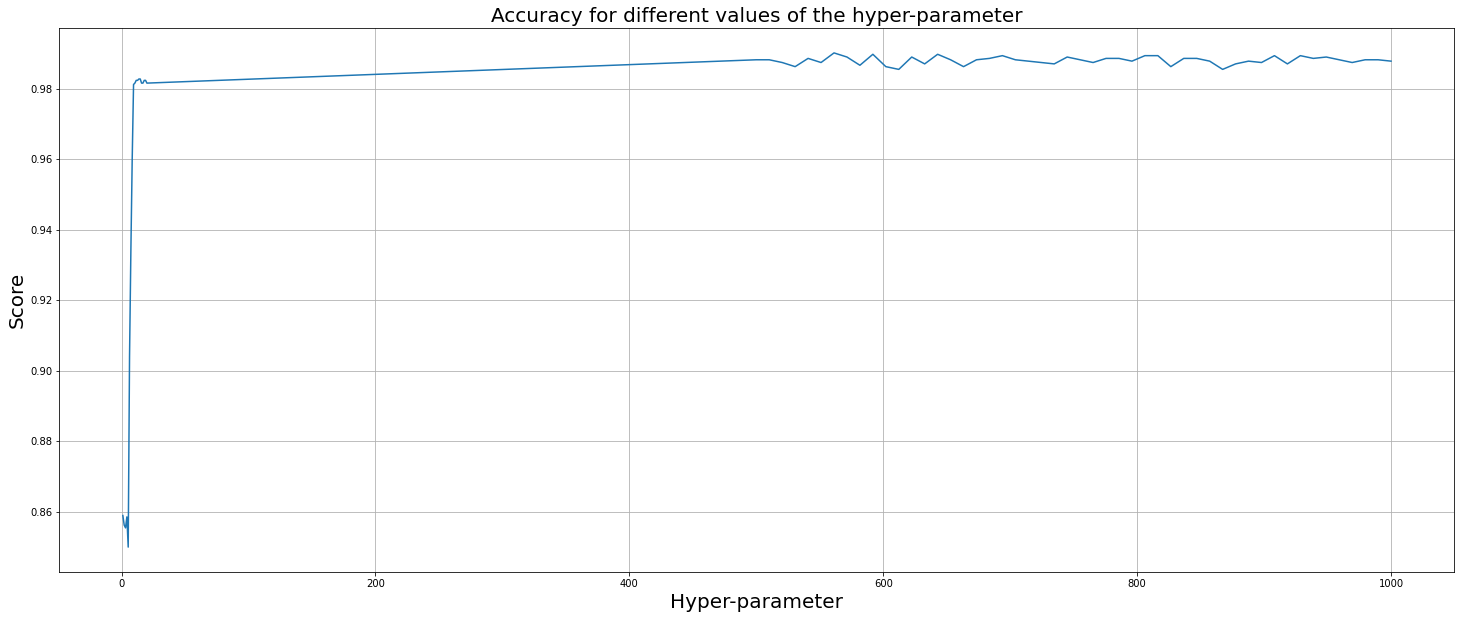

In [14]:
# Plot
plt.figure(figsize=(25,10))
plt.plot(regulation_parameter_range[1:], scores[1:])
plt.title("Accuracy for different values of the hyper-parameter", size=20)
plt.xlabel("Hyper-parameter", size=20)
plt.ylabel("Score", size=20)
plt.grid()
plt.show()

We also plot the accuracy for the smaller set of values for the hyper-parameter.

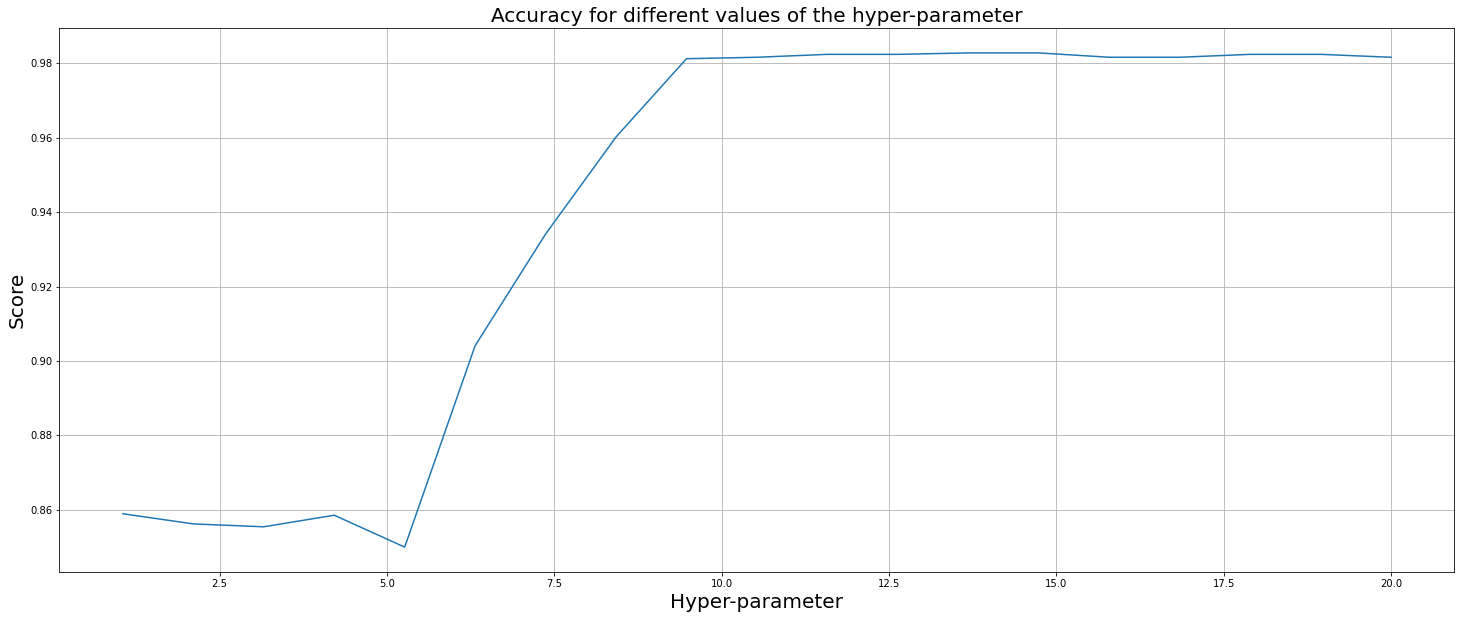

For zero hyper parameter we get an accuracy of:  0.0


In [15]:
# Plot
plt.figure(figsize=(25,10))
plt.plot(regulation_parameter_range[1:20], scores[1:20])
plt.title("Accuracy for different values of the hyper-parameter", size=20)
plt.xlabel("Hyper-parameter", size=20)
plt.ylabel("Score", size=20)
plt.grid()
plt.show()

# Print score for zero hyper-parameter
print("For zero hyper parameter we get an accuracy of: ", scores[0])

We will now discuss the variability of the accuracy as we change the hyper-parameter. On the plot we show the accuracy for different lambda. 

If we imagine the $2D$ case, this corresponds to the two classes being separated by a 'road' where we want the width of the road to be maximal and we also want as many as possible of the points to be correctly classified. 

When the hyper-parameter is relatively high, we put most of the weight of the hinge loss function on the constraint which penalises wrongly classified points. This means that the width of the 'road' is of little to no importance as we increase $\lambda$ and in the limit, we approach the case of hard-margin SVM where we attempt to draw a line (in $2D$ case) with zero width separating the two classes (although it is not always possible to perfectly separate the two classes, but in our case we seem to be very close to do so as the accuracy is very close to $1$).

For low values of the hyper-parameter, we put bigger weight on the width of the 'road' at the expense of the amount of wrongly classified points. As $\lambda$ goes to zero, we put the entire weight on the width and disregard how many points are wrongly classified, hence we get very low accuracy. For our data, we see that the width of the road is of very low importance as we get higher accuracies for large $\lambda$. To avoid overfitting the model however, we need to consider the tumour_test.csv dataset as we do in the next section.

We now evaluate the performance of the model on the tumour_test.csv dataset. First we calculate the weights from the train data with the optimal value of lambda found above and use it to compute the accuracy on the test data that we have not used so far. 

In [16]:
# Response test data
diag_map = {'M': 1.0, "B": -1.0}
y_tumor_test = tumour_test['DIAGNOSIS'].map(diag_map).to_numpy()

In [17]:
w = sgd(X_tumor_train_std, 
        y_tumor_train,
        max_iterations=1025,
        stop_criterion=0.01,
        learning_rate=1e-5,
        regulation_parameter=optimal_regulation_parameter)

print("Accuracy on tain data: ", optimal_score)
print("Accuracy on test data: ", score_svm(w, X_tumor_test_std, y_tumor_test))

Accuracy on tain data:  0.9902534113060428
Accuracy on test data:  0.985


We can see that the accuracy is very high and similar to the optimal score on the train data from the previous section, which suggests that our model did not overfit. 

Next, we plot a ROC curve using the function below taken from the Logistic Regression coding task and slightly modified. For our thresholds, we use the quantity $X @ w$ as if this is close to zero (i.e. a point is close to the line separating the two classifications) then it is likely that it is wrongly classified. By that we mean that the farther away a point is from the line (i.e. the farther away $X @ w$ is from $0$) the larger the probability that we have correctly classified that point. So $X @ w$ could be interpreted as the equivalent of the probabilities in the logistic regression.

In [18]:
# Response test data
diag_map = {'M': 1, "B": 0}
y_tumor_test = tumour_test['DIAGNOSIS'].map(diag_map).to_numpy()

In [19]:
def roc_curve(y_test, y_prediction_svm):
  """
  Arguments:
  y_test: ground truth labels
  y_prediction_svm: values produced by svm model
  
  Returns:
  AUC: area under the curve.
  TPR_values: a list of true positive rate (TPR) values for each scanned threshold.
  FPR_values: a list of false positive rate (FPR) values for each scanned threshold.
  """
  # List of distinct values in y_prediction_svm, sorted descendingly.
  thresholds = reversed(sorted(set(y_prediction_svm))) 
  TPR_values, FPR_values = [], []

  for threshold in thresholds:
    # Apply thresholding
    y_thresholded = (y_prediction_svm >= threshold)

    # True positives
    TP = np.sum(y_test & y_thresholded)
    # True negatives
    TN = np.sum((~y_test) & (~y_thresholded))
    # False positives
    FP = np.sum((~y_test) & y_thresholded)
    # False negatives
    FN = np.sum(y_test & (~y_thresholded))

    TPR = TP / (TP + FN)
    FPR = FP / (TN + FP)
    TPR_values.append(TPR)
    FPR_values.append(FPR)

  # Compute AUC using Trapezoidal rule
  AUC = np.trapz(TPR_values, FPR_values)

  return TPR_values, FPR_values, AUC

We now create a function that plots the ROC curves for a given value of the hyper-parameter. We compute the weights using our Stochastic Gradient Descent function and then we create a plot of TPR vs FPR for each hyper-parameter in a given range. We return the area under the curve (AUC) values since we plot them as well afterwards.

In [20]:
def plot_roc_curves(X_train, y_train, X_test, y_test, regulation_parameter_range):
    """Plot ROC curves for a range of hyper-parameters and returns the AUC values."""

    # store AUC values
    AUC_values = []

    # colors for plots
    colors = plt.cm.jet(np.linspace(0, 1, 100))

    for regulation_parameter, c in zip(regulation_parameter_range, colors):
        
        # compute weights for a given hyper-parameter
        w = sgd(X_train, y_train,
                max_iterations=1025,
                stop_criterion=0.01,
                learning_rate=1e-5,
                regulation_parameter=regulation_parameter)
    
        # compute predictions for thresholding
        y_predictions = X_test @ w

        TPR, FPR, AUC = roc_curve(y_test, y_predictions)
        
        AUC_values.append(AUC)

        # plot
        plt.plot(FPR, TPR, color = c)
    
    return AUC_values

Below we create the plot. The curves are all above the diagonal line, which means that the model is doing better than a completely random classifier (under the diagonal line the model would be doing worse than random). For small values of the hyper-parameter the model is doing worse than for larger values, where we see that it approaches the corner $FPR = 0$ and $TPR = 1$. 

We have also created a plot of the area under the curve as the hyper-parameter changes. It is an overall measure of the quality of the model, and we would want to see that the AUC is greater than $0.5$ meaning that the model is performing better than random. Once again, as the hyper-parameter increases the AUC is very close to $1$.

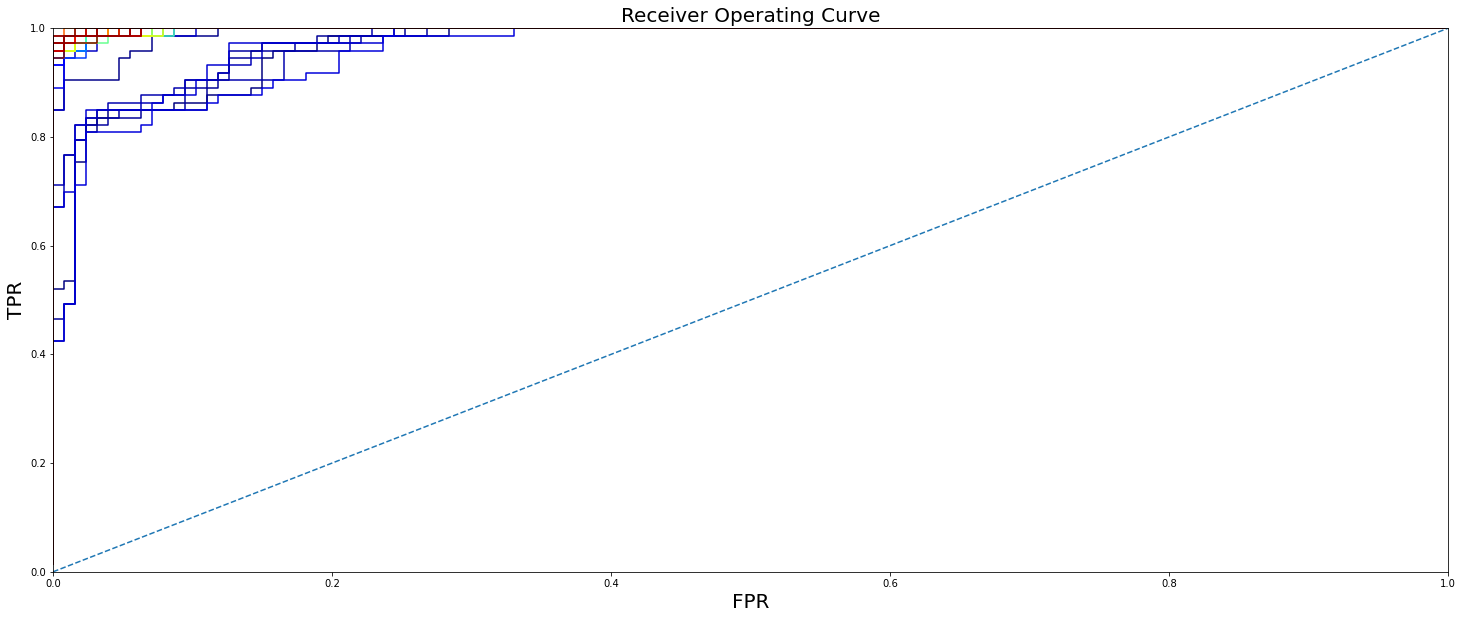

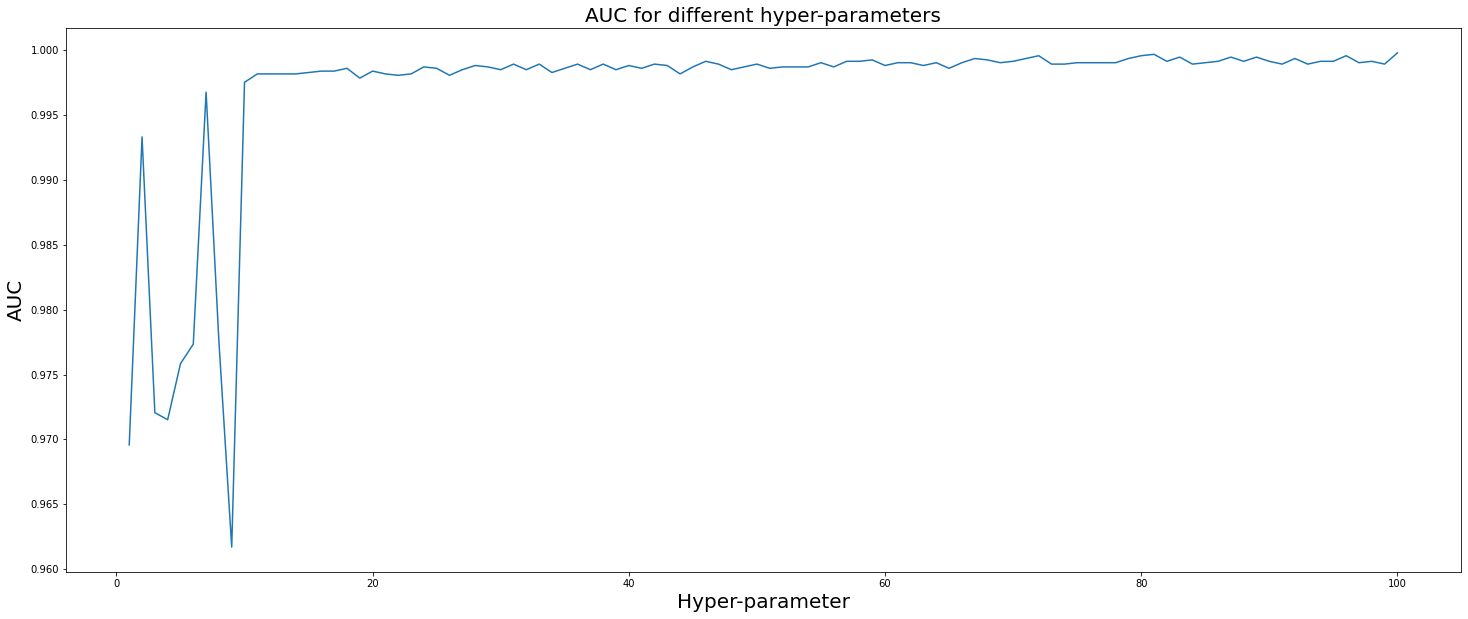

In [21]:
# set range for the hyper-parameter
regulation_parameter_range = np.linspace(1,100,100)

# plot receiver operating characteristic curves
plt.figure(figsize=(25,10))
AUC_values = plot_roc_curves(X_tumor_train_std, 
                             y_tumor_train,
                             X_tumor_test_std,
                             y_tumor_test,
                             regulation_parameter_range = regulation_parameter_range)
plt.plot([0, 1], [0, 1], 'C0--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title(f"Receiver Operating Curve", size=20)
plt.ylabel('TPR', size=20)
plt.xlabel('FPR', size=20)
plt.show()

# plot AUC values
plt.figure(figsize=(25,10))
plt.plot(regulation_parameter_range, AUC_values)
plt.title("AUC for different hyper-parameters", size=20)
plt.xlabel("Hyper-parameter", size=20)
plt.ylabel("AUC", size=20)
plt.show()

As we can see, as the hyper-parameter increases so does our accuracy and the AUC. For large enough lambda we see that the AUC is very close to 1 and on the ROC curve this is represented by the red-colored curves, which approach the corner (0,1) as expected, while for lower values of lambda we are closer to the diagonal line. Due to the stochastic nature of the model, the choice of the hyper-parameter will vary, but it is important to note that the larger value of lambda we have, the more accurate our model is.

We now work with the balanced tumour dataset. As before, we standardise and use the mean and standard deviation to standardise the test set, map the categorical labels to $1$ and $-1$. We also insert an intercept column of ones. 

In [23]:
diag_map = {'M': 1.0, 'B': -1.0}
tumour_samples_bal = pd.read_csv('tumour_samples_bal.csv')
tumour_samples_bal['DIAGNOSIS'] = tumour_samples_bal['DIAGNOSIS'].map(diag_map)

# Predictor data
X_tumor_train_bal = tumour_samples_bal.iloc[:, 1: -1]

# save the mean and std to standardize the X_tumor_test dataset
mu, sigma = np.mean(X_tumor_train_bal, axis = 0), np.std(X_tumor_train_bal, axis = 0)

# standardize
X_tumor_train_bal_std = (X_tumor_train_bal - mu) / sigma  

 # insert intercept column with ones
X_tumor_train_bal_std.insert(loc=len(X_tumor_train_bal_std.columns), column='intercept', value=1)
X_tumor_train_bal_std = X_tumor_train_bal_std.to_numpy()

# Response data
y_tumor_train_bal = tumour_samples_bal.loc[ : , "DIAGNOSIS"].to_numpy()

We perform 5-fold cross validation to find the optimal hyper-parameter with the balanced dataset.

In [24]:
# set range for the hyper-parameter
regulation_parameter_range = np.append(np.linspace(0,20,20), np.linspace(500,1000,50))

#create folds
folds = cross_validation_split(X_tumor_train_bal_std.shape[0], num_folds=5)

# compute the optimal parameter and store all scores
optimal_regulation_parameter_bal, scores_bal, optimal_score_bal = choose_best_regulation_parameter(X_tumor_train_bal_std,
                                                                                                   y_tumor_train_bal,
                                                                                                   folds,
                                                                                                   regulation_parameter_range)

In [25]:
# print the optimal hyper-parameter for the balanced dataset
print("Optimal balanced hyper-parameter: ", optimal_regulation_parameter_bal)
print("Mean accuracy for the balanced optimal parameter: ", optimal_score_bal)

Optimal balanced hyper-parameter:  602.0408163265306
Mean accuracy for the balanced optimal parameter:  0.9762500000000001


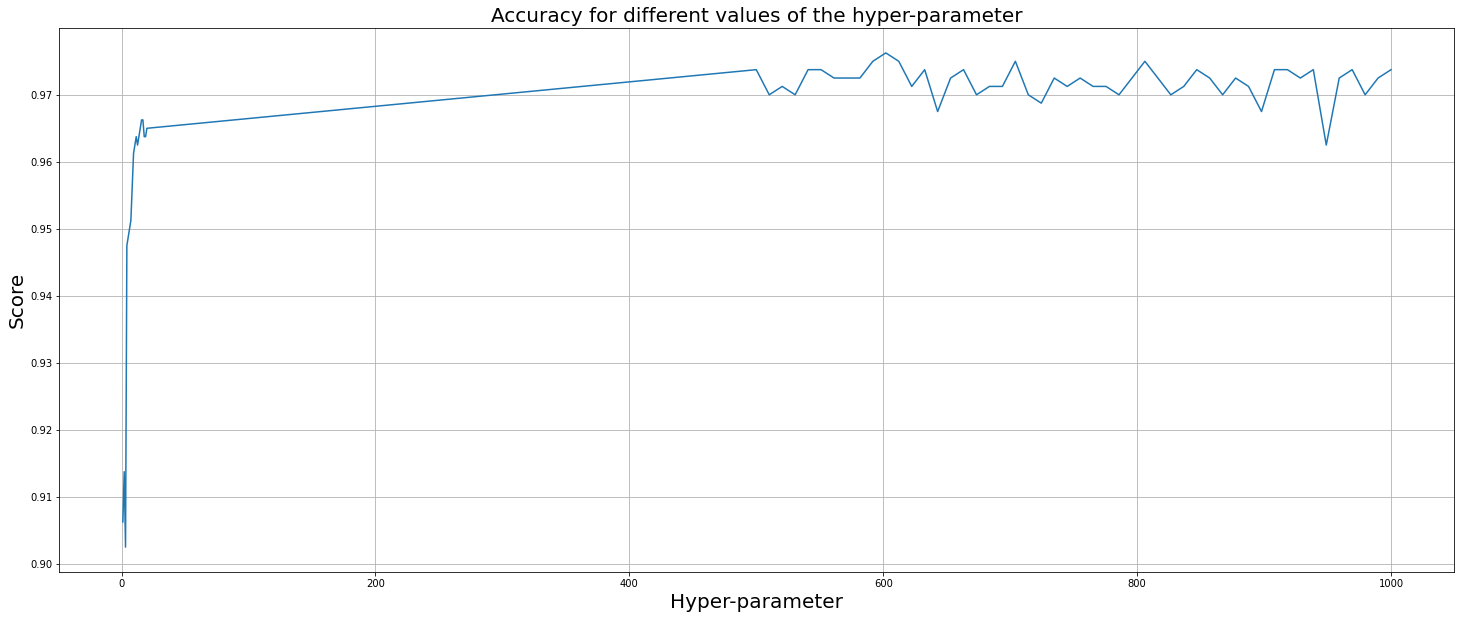

In [26]:
# plot
plt.figure(figsize=(25,10))
plt.plot(regulation_parameter_range[1:], scores_bal[1:])
plt.title("Accuracy for different values of the hyper-parameter", size=20)
plt.xlabel("Hyper-parameter", size=20)
plt.ylabel("Score", size=20)
plt.grid()
plt.show()

Once again, we also create a plot only for the smaller values of the hyper-parameter.

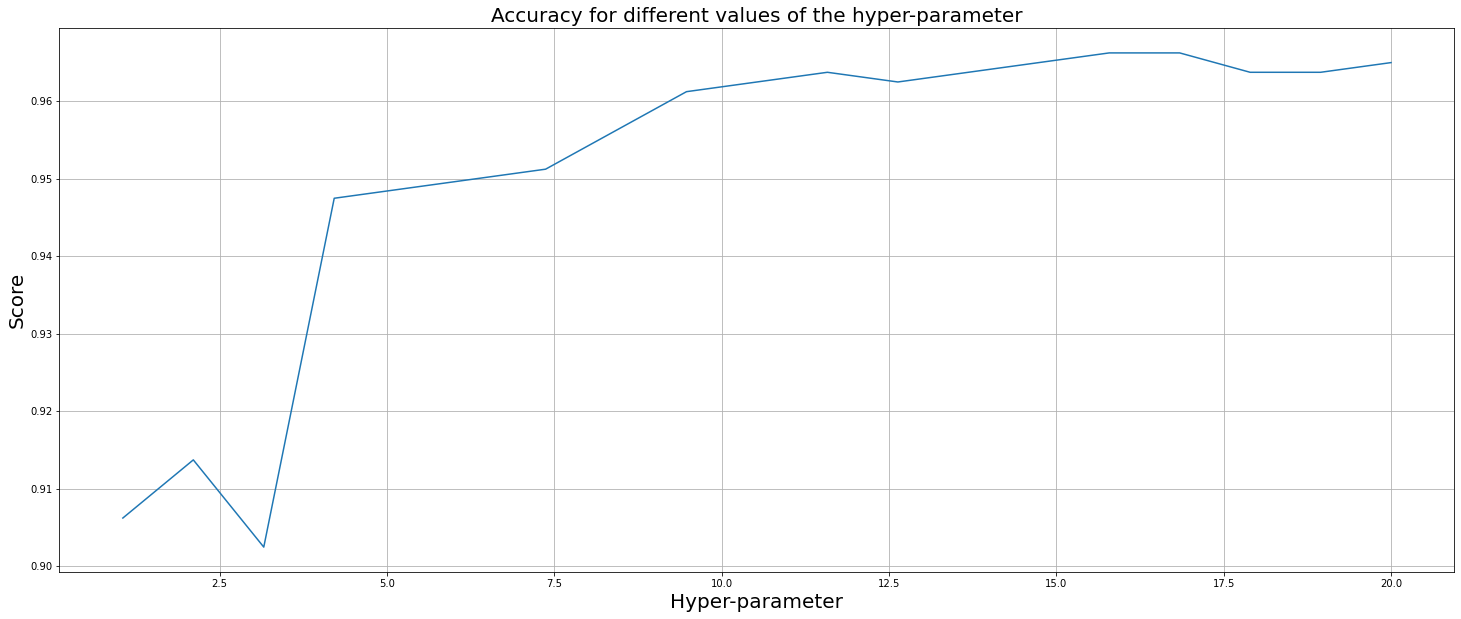

In [27]:
# plot
plt.figure(figsize=(25,10))
plt.plot(regulation_parameter_range[1:20], scores_bal[1:20])
plt.title("Accuracy for different values of the hyper-parameter", size=20)
plt.xlabel("Hyper-parameter", size=20)
plt.ylabel("Score", size=20)
plt.grid()
plt.show()

In comparison to the imbalanced dataset, we notice that for larger values of lambda there appears to be more variablility in the accuracy.

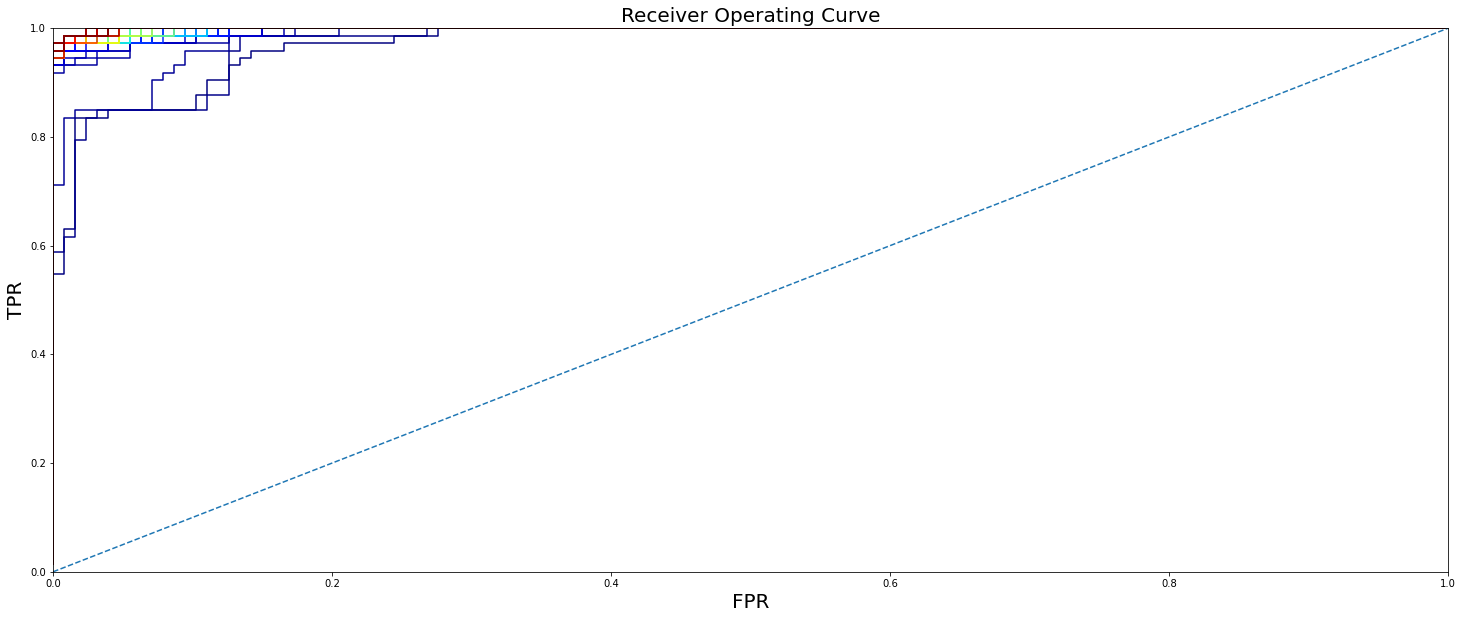

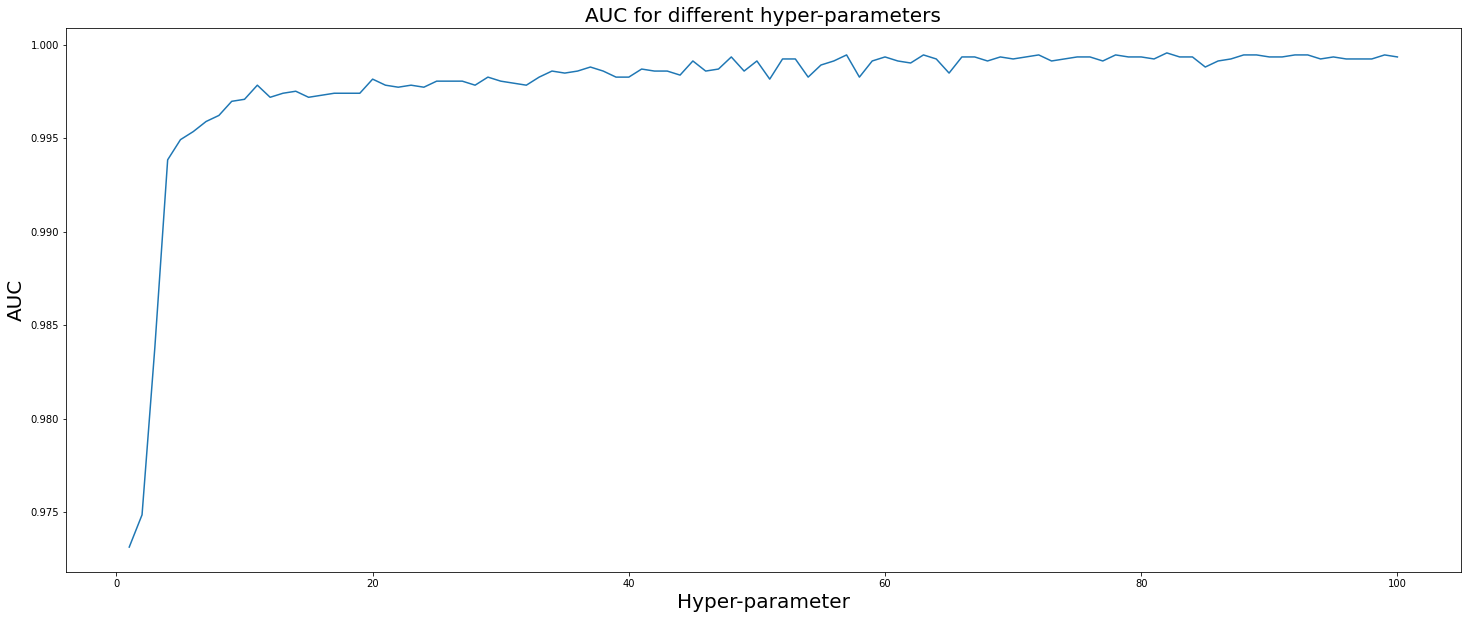

In [28]:
# set range for the hyper-parameter
regulation_parameter_range = np.linspace(1,100,100)

# plot receiver operating characteristic curves
plt.figure(figsize=(25,10))
AUC_values = plot_roc_curves(X_tumor_train_bal_std, 
                             y_tumor_train_bal,
                             X_tumor_test_std,
                             y_tumor_test,
                             regulation_parameter_range = regulation_parameter_range)
plt.plot([0, 1], [0, 1], 'C0--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title(f"Receiver Operating Curve", size=20)
plt.ylabel('TPR', size=20)
plt.xlabel('FPR', size=20)
plt.show()

# plot AUC values
plt.figure(figsize=(25,10))
plt.plot(regulation_parameter_range, AUC_values)
plt.title("AUC for different hyper-parameters", size=20)
plt.xlabel("Hyper-parameter", size=20)
plt.ylabel("AUC", size=20)
plt.show()

Now we compare the balanced and imbalanced datasets. From the ROC curves, we can see that the balanced dataset performs better for smaller values of the hyper-parameter and similar to the imbalanced dataset converges to the corner $(0,1)$. The plot on the accuracy however shows that for larger lambdas, there is more variablility in the accuracy of the balanced dataset, however this may be because of the stochastic nature of our model (and we may need to increase number of iterations in our sgd function). 

In the balanced dataset we lose information on the frequency of events (in our case the frequency of malignant tumors), which is worth mentioning as it may affect our preference on a dataset depending on what information we need.